In [29]:
from MyModels import *
plt.rcParams['figure.figsize'] = [20, 5]
%matplotlib inline  

In [2]:
f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

In [63]:
data = pd.read_feather(f_data_path + "LPG-Profile-4.feather")

In [39]:
x = data['energy']
x = np.sum(x.values.reshape(-1,180),axis=1)

In [66]:
split = 0.8
l = int(1000 * split)
e = int(1000 * (1-split))
x_train = x[0:l].reshape(-1,1)
y_train = x[1:l+1].reshape(-1,1)
x_valid = x[l+2:l+e - 1].reshape(-1,1)
y_valid = x[l+3:l+e].reshape(-1,1)

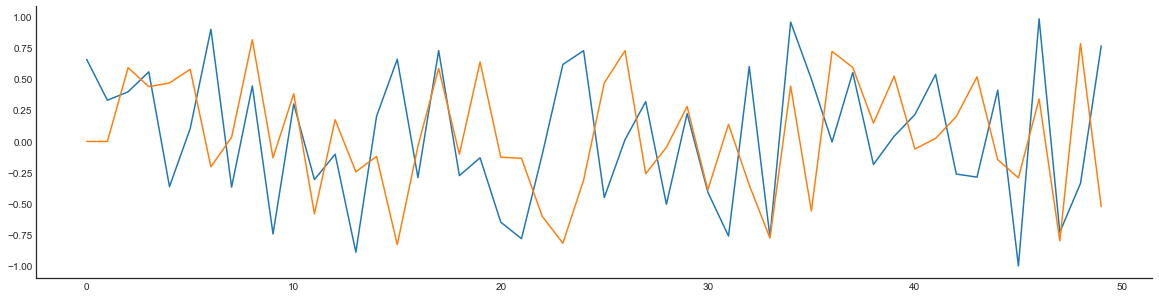

In [32]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(x_train[0:50])
plt.plot(y_train[0:50])

In [47]:
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
x_train, x_valid, y_train, y_valid = get_siso_data(
  n=1000,
  colored_noise=False,
  sigma=0.001,
  train_percentage=80
)

In [52]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation

basis_function=Polynomial(degree=2)
model = FROLS(
  order_selection=True,
  n_info_values=10,
  extended_least_squares=False,
  ylag=2,
  xlag=2,
  info_criteria='aic',
  estimator='least_squares',
  basis_function=basis_function
)
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)
r = pd.DataFrame(
	results(
		model.final_model, model.theta, model.err,
		model.n_terms, err_precision=8, dtype='sci'
		),
	columns=['Regressors', 'Parameters', 'ERR'])
print(r)

5.699683291046931
      Regressors   Parameters             ERR
0              1   1.8619E+00  4.72169796E-01
1         y(k-2)  -6.8427E-01  3.31228206E-02
2   y(k-2)y(k-1)   1.5576E-01  2.55582011E-02
3        x1(k-2)  -4.2413E-01  8.88279998E-03
4  x1(k-2)y(k-2)   1.8083E-01  2.39008348E-02
5       y(k-1)^2  -3.6379E-02  2.78885761E-03
6  x1(k-2)y(k-1)   8.4233E-02  3.73438465E-03


08-12 19:03:54 - INFO - Train metrics: 1.392541669962699 | Validation metrics: 1.7745691009403504
08-12 19:03:54 - INFO - Train metrics: 1.0998119465390543 | Validation metrics: 1.5008102212984538
08-12 19:03:54 - INFO - Train metrics: 1.027631896181513 | Validation metrics: 1.4519858421738614
08-12 19:03:54 - INFO - Train metrics: 0.9814641753533729 | Validation metrics: 1.3801125533801992
08-12 19:03:54 - INFO - Train metrics: 0.9609838081780532 | Validation metrics: 1.3418261353502567
08-12 19:03:54 - INFO - Train metrics: 0.9389667884449014 | Validation metrics: 1.3447896881201833
08-12 19:03:54 - INFO - Train metrics: 0.9269584763916513 | Validation metrics: 1.3373743111325294
08-12 19:03:55 - INFO - Train metrics: 0.9165020903250328 | Validation metrics: 1.3354748856161058
08-12 19:03:55 - INFO - Train metrics: 0.9074489487741226 | Validation metrics: 1.3163335630574178
08-12 19:03:55 - INFO - Train metrics: 0.9012240022047421 | Validation metrics: 1.3399612842146884
08-12 19:03:

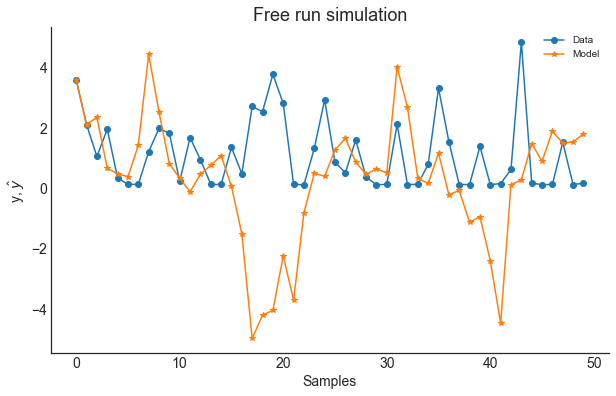

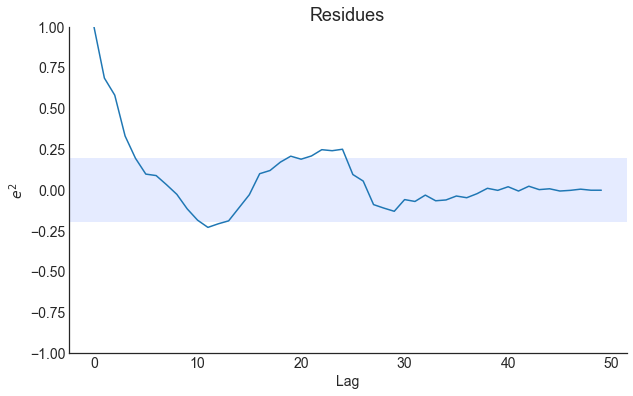

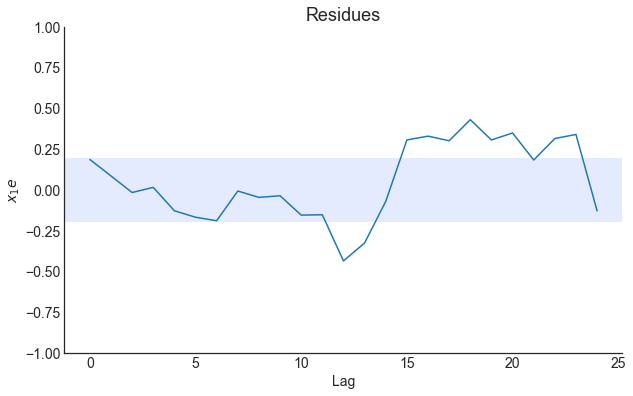

In [72]:
from torch import nn
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()
        # self.lin = nn.Linear(34, 100)
        # self.lin2 = nn.Linear(100, 100)
        # self.lin3 = nn.Linear(100, 1)
        # self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

basis_function=Polynomial(degree=3)

narx_net = NARXNN(
  net=NARX(),
  ylag=2,
  xlag=2,
  basis_function=basis_function,
  model_type="NARMAX",
  loss_func='mse_loss',
  optimizer='Adam',
  epochs=200,
  verbose=True,
  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

narx_net.fit(X=x_train, y=y_train,X_test=x_valid, y_test=y_valid)
yhat = narx_net.predict(X=x_valid[:50], y=y_valid[:50])
plot_results(y=y_valid[:50], yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid[:50], yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid[:50], yhat, x_valid[:50])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")